Compare my build model to pre-build XGBooster random forest for compare the accuracy. I got similar accuracy (0.84 vs 0.85) and the build model show a recall score (0.90 vs 0.75) and F1 score (0.74 vs 0.71)

In [1]:
import cudf
import cuml
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
df = cudf.read_parquet('df.parquet')

In [3]:
# Select target and features
y = df['target']
X = df.drop('target', axis=1)

In [4]:
accuracies = []
precisions = []
recalls = []
f1_scores = []

In [5]:
X_train_np = X.to_pandas().values
y_train_np = y.to_pandas().values

In [6]:
# Define the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True)

In [7]:

# Loop over KFold splits for importance feature
for train_index, test_index in kf.split(X_train_np, y_train_np):
    # Indexing using numpy arrays or pandas DataFrames
    X_train_fold, X_test_fold = X_train_np[train_index], X_train_np[test_index]
    y_train_fold, y_test_fold = y_train_np[train_index], y_train_np[test_index]

    # Train the XGBoost model
    xgb_model = xgb.XGBRFRegressor(
        colsample_bynode=0.8,
        learning_rate=1,
        max_depth=5,
        num_parallel_tree=100,
        objective="binary:logistic",
        subsample=0.8,
        tree_method="hist",
        device="cuda",
        random_state=42
    )
    xgb_model.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold_prob = xgb_model.predict(X_test_fold)

    # Convert probabilities to binary predictions (using 0.5 as the threshold)
    y_pred_fold = (y_pred_fold_prob > 0.5).astype(int)

    # Calculate metrics for this fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold)
    recall = recall_score(y_test_fold, y_pred_fold)
    f1 = f1_score(y_test_fold, y_pred_fold)

    # Append metrics to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Print metrics for the current fold
    print(f'Fold Accuracy: {accuracy:.4f}')
    print(f'Fold Precision: {precision:.4f}')
    print(f'Fold Recall: {recall:.4f}')
    print(f'Fold F1 Score: {f1:.4f}')
    print(confusion_matrix(y_test_fold, y_pred_fold))
    print(classification_report(y_test_fold, y_pred_fold, target_names=['Non-Fraud', 'Fraud']))

# Calculate and print average metrics
print(f'Average Accuracy: {np.mean(accuracies):.4f}')
print(f'Average Precision: {np.mean(precisions):.4f}')
print(f'Average Recall: {np.mean(recalls):.4f}')
print(f'Average F1 Score: {np.mean(f1_scores):.4f}')

Time = time.process_time()
print(f'Time')

/home/simon/miniconda3/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:38:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Fold Accuracy: 0.8545
Fold Precision: 0.6920
Fold Recall: 0.7491
Fold F1 Score: 0.7194
[[738826  91887]
 [ 69131 206447]]
              precision    recall  f1-score   support

   Non-Fraud       0.91      0.89      0.90    830713
       Fraud       0.69      0.75      0.72    275578

    accuracy                           0.85   1106291
   macro avg       0.80      0.82      0.81   1106291
weighted avg       0.86      0.85      0.86   1106291

Fold Accuracy: 0.8543
Fold Precision: 0.6909
Fold Recall: 0.7506
Fold F1 Score: 0.7195
[[738452  92465]
 [ 68679 206694]]
              precision    recall  f1-score   support

   Non-Fraud       0.91      0.89      0.90    830917
       Fraud       0.69      0.75      0.72    275373

    accuracy                           0.85   1106290
   macro avg       0.80      0.82      0.81   1106290
weighted avg       0.86      0.85      0.86   1106290

Fold Accuracy: 0.8543
Fold Precision: 0.6924
Fold Recall: 0.7471
Fold F1 Score: 0.7187
[[739098  91507

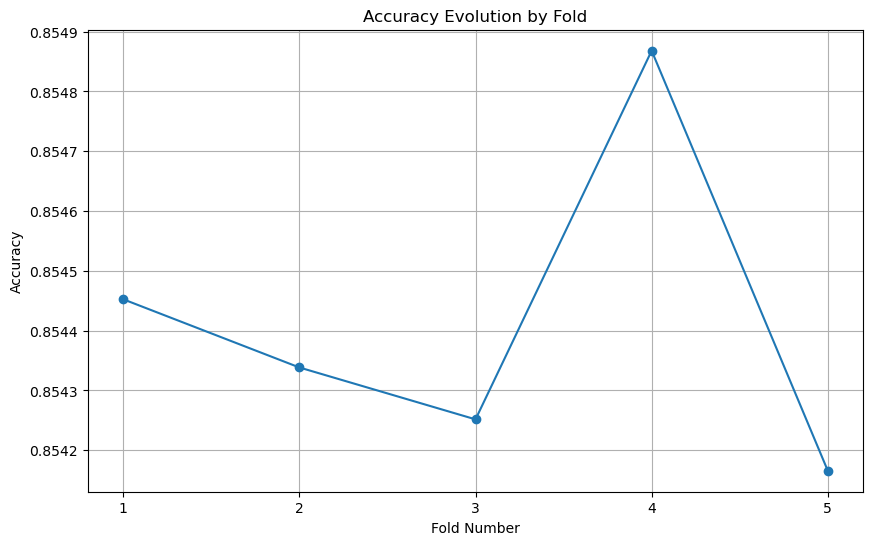

In [8]:
# Plot the accuracy evolution by fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution by Fold')
plt.grid(True)
plt.xticks(range(1, len(accuracies) + 1))
plt.show()